In [155]:
from comet_ml import Experiment
####

In [156]:
import IPython.display as ipd
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
from sklearn import metrics 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
import certifi
import os

In [157]:
experiment = Experiment(api_key = "dyv0D7GcXUxTpKqVkzCY3qJwb",
                        project_name="SpecRec", log_code=True)

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/typerw/specrec/0a1c680dc3f143029886b694961818f6
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO: ---------------------------
COMET ERROR: Error sending notification, make sure you have opted-in for notifications
COMET ERROR: Failed to report experiment status
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/typerw/specrec/19a8cb8c0d694930a6ba5f9f587db1f9



In [158]:
labels = ['drzwi', 'garaz', 'okno', 'otworz', 'zamknij']
PATH = "./nagrania/"

In [159]:
def load_files(path, labels):
    # write the complete file loading function here, this will return
    # a dataframe having files and labels
    # loading the files
    train_labels = os.listdir(PATH)

    labels_to_keep = labels

    train_file_labels = dict()
    
    for label in train_labels:
        if label == '.DS_Store':
            pass
        else:
            files = os.listdir(PATH + '/' + label)
            for f in files:
                if f == '.DS_Store':
                    pass
                else:
                    train_file_labels[label + '/' + f] = label

    train = pd.DataFrame.from_dict(train_file_labels, orient='index')
    train = train.reset_index(drop=False)
    train = train.rename(columns={'index': 'file', 0: 'folder'})
    train = train[['folder', 'file']]
    train = train.sort_values('file')
    train = train.reset_index(drop=True)

    def remove_label_from_file(label, fname):
        return path + label + '/' + fname[len(label) + 1:]

    train['file'] = train.apply(lambda x: remove_label_from_file(*x), axis=1)
    train['label'] = train['folder'].apply(lambda x: x if x in labels_to_keep else 'unknown')

    labels_to_keep.append('unknown')
     
    return train, labels_to_keep

In [160]:
train_labels = os.listdir(PATH)
train, labels_to_keep = load_files(PATH, labels)

In [161]:
train[train.label =='okno']

,folder,file,label
32,okno,./nagrania/okno/Okno 19-1.wav,okno
33,okno,./nagrania/okno/Okno 19-2.wav,okno
34,okno,./nagrania/okno/Okno 19-3.wav,okno
35,okno,./nagrania/okno/Okno 19-4.wav,okno
36,okno,./nagrania/okno/Okno 22-1.wav,okno
37,okno,./nagrania/okno/Okno 22-2.wav,okno
38,okno,./nagrania/okno/Okno 22-3.wav,okno
39,okno,./nagrania/okno/Okno 22-4.wav,okno
40,okno,./nagrania/okno/Okno 23-1.wav,okno
41,okno,./nagrania/okno/Okno 23-2.wav,okno


In [162]:
for i in range(train.shape[0]):
    experiment.log_audio(train.file[i], metadata = {'name': train.label[i]})

In [163]:
fn = train.file[i]
librosa_audio, librosa_sample_rate = librosa.load(fn)
scipy_sample_rate, scipy_audio = wav.read(fn)
print("Original sample rate: {}".format(scipy_sample_rate))
print("Librosa sample rate: {}".format(librosa_sample_rate))

Original sample rate: 48000
Librosa sample rate: 22050


In [164]:
print('Original audio file min~max range: {} to {}'.format(np.min(scipy_audio), np.max(scipy_audio)))
print('Librosa audio file min~max range: {0:.2f} to {0:.2f}'.format(np.min(librosa_audio), np.max(librosa_audio)))

Original audio file min~max range: -21325 to 21750
Librosa audio file min~max range: -0.65 to -0.65


{'web': 'https://www.comet.ml/api/image/download?imageId=1700f1791664464dae8e3d9decca39a6&experimentKey=19a8cb8c0d694930a6ba5f9f587db1f9',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=1700f1791664464dae8e3d9decca39a6&experimentKey=19a8cb8c0d694930a6ba5f9f587db1f9',
 'imageId': '1700f1791664464dae8e3d9decca39a6'}

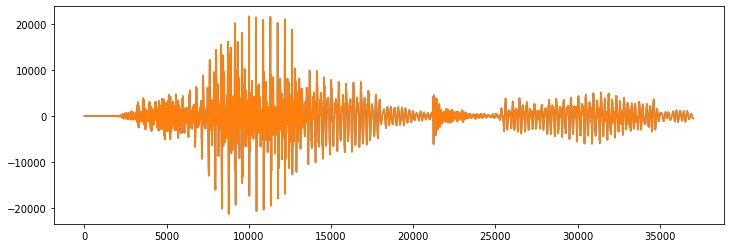

In [165]:
plt.figure(figsize=(12, 4))
plt.plot(scipy_audio)
plt.savefig('original_audio.png')
experiment.log_image('original_audio.png')

{'web': 'https://www.comet.ml/api/image/download?imageId=99727b050b1e4c6b858abacebb2ec226&experimentKey=19a8cb8c0d694930a6ba5f9f587db1f9',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=99727b050b1e4c6b858abacebb2ec226&experimentKey=19a8cb8c0d694930a6ba5f9f587db1f9',
 'imageId': '99727b050b1e4c6b858abacebb2ec226'}

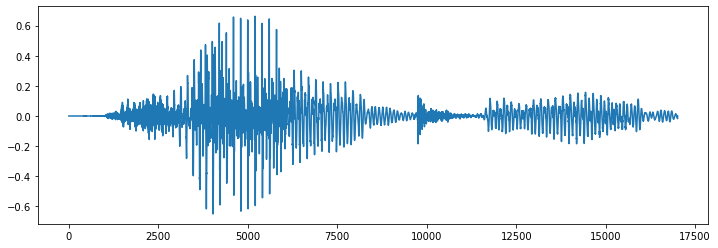

In [166]:
# Librosa: mono track
plt.figure(figsize=(12,4))
plt.plot(librosa_audio)
plt.savefig('librosa_audio.png')
experiment.log_image('librosa_audio.png')

In [167]:
mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc = 40)

In [168]:
print(mfccs.shape)

(40, 34)


In [169]:
def extract_features(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_processed = np.mean(mfccs.T,axis=0)
     
    return mfccs_processed

In [170]:
features = []
# Iterate through each sound file and extract the features 
for index, row in train.iterrows():
    
    file_name = row['file']
    class_label = row["label"]
    data = extract_features(file_name)
    
    features.append([data, class_label])
# Convert into a Panda dataframe 
    featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

In [171]:
featuresdf

,feature,class_label
0,"[-323.64352, 78.34826, -28.102926, 66.6308, 1....",drzwi
1,"[-315.9747, 85.08107, -27.019323, 60.881153, 0...",drzwi
2,"[-315.72263, 84.4411, -26.812078, 61.01948, 0....",drzwi
3,"[-282.00342, 62.84759, -52.50572, 73.47285, 20...",drzwi
4,"[-497.7464, 69.746574, 7.423347, 35.55713, -14...",drzwi
...,...,...
75,"[-341.5836, 112.8678, -4.8976617, 22.871546, -...",zamknij
76,"[-317.24463, 102.52461, -12.1172695, 27.954376...",zamknij
77,"[-290.26773, 133.23805, -22.49523, 22.46734, -...",zamknij
78,"[-342.12854, 120.12017, -19.254522, 18.76213, ...",zamknij


In [172]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())
# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

In [173]:
# split the dataset 
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 127)

In [174]:
num_labels = yy.shape[1]
filter_size = 2
model = Sequential()
model.add(Dense(256, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [175]:
# Display model architecture summary 
model.summary()
# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 256)               10496     
_________________________________________________________________
activation_6 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_7 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                

In [176]:
print("Pre-training accuracy: %.4f%%" % accuracy)

Pre-training accuracy: 25.0000%


In [177]:
from tensorflow.keras.callbacks import ModelCheckpoint 
from datetime import datetime 
num_epochs = 100
num_batch_size = 32
model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), verbose=1)

Epoch 1/100
2/2 [==============================] - 0s 37ms/step - loss: 37.3009 - accuracy: 0.2031 - val_loss: 15.8753 - val_accuracy: 0.2500
Epoch 2/100
2/2 [==============================] - 0s 32ms/step - loss: 35.6104 - accuracy: 0.1719 - val_loss: 13.0400 - val_accuracy: 0.1875
Epoch 3/100
2/2 [==============================] - 0s 37ms/step - loss: 38.2933 - accuracy: 0.1406 - val_loss: 9.0888 - val_accuracy: 0.1875
Epoch 4/100
2/2 [==============================] - 0s 30ms/step - loss: 33.6075 - accuracy: 0.1406 - val_loss: 5.4695 - val_accuracy: 0.5000
Epoch 5/100
2/2 [==============================] - 0s 30ms/step - loss: 32.3608 - accuracy: 0.1562 - val_loss: 7.4926 - val_accuracy: 0.3125
Epoch 6/100
2/2 [==============================] - 0s 44ms/step - loss: 30.7058 - accuracy: 0.2656 - val_loss: 7.2953 - val_accuracy: 0.2500
Epoch 7/100
2/2 [==============================] - 0s 35ms/step - loss: 20.6811 - accuracy: 0.2344 - val_loss: 5.6464 - val_accuracy: 0.3125
Epoch 8/100

Epoch 59/100
2/2 [==============================] - 0s 36ms/step - loss: 3.0949 - accuracy: 0.6094 - val_loss: 1.0260 - val_accuracy: 0.6250
Epoch 60/100
2/2 [==============================] - 0s 51ms/step - loss: 2.7630 - accuracy: 0.5469 - val_loss: 1.0412 - val_accuracy: 0.6250
Epoch 61/100
2/2 [==============================] - 0s 74ms/step - loss: 2.3782 - accuracy: 0.6562 - val_loss: 1.0071 - val_accuracy: 0.6250
Epoch 62/100
2/2 [==============================] - 0s 40ms/step - loss: 2.4804 - accuracy: 0.6094 - val_loss: 0.9623 - val_accuracy: 0.6250
Epoch 63/100
2/2 [==============================] - 0s 38ms/step - loss: 2.1500 - accuracy: 0.6406 - val_loss: 0.9124 - val_accuracy: 0.6250
Epoch 64/100
2/2 [==============================] - 0s 49ms/step - loss: 2.7109 - accuracy: 0.6562 - val_loss: 0.8497 - val_accuracy: 0.6875
Epoch 65/100
2/2 [==============================] - 0s 36ms/step - loss: 3.2975 - accuracy: 0.5781 - val_loss: 0.7948 - val_accuracy: 0.7500
Epoch 66/100


In [178]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: {0:.2%}".format(score[1]))
score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: {0:.2%}".format(score[1]))

Training Accuracy: 87.50%
Testing Accuracy: 81.25%


In [180]:
feature = []
file_to_check = train.file[3]
print(file_to_check)
feature.append(extract_features(file_to_check))
tst = np.array(feature)
prediction = model.predict(tst)
"Checked file contains a word {} with {:.2%} certain.".format((le.inverse_transform(prediction.argmax(axis=-1))[0]), prediction[0,prediction.argmax(axis=-1)][0])  


./nagrania/drzwi/Drzwi 19-4.wav


'Checked file contains a word drzwi with 100.00% certain.'